In [1]:
#hide
!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org -Uqq fastbook
!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org -Uqq fastai
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *

# A Language Model from Scratch

<< chapter_nlp >>에서 사전 훈련 된 언어 모델을 미세 조정하여 텍스트 분류기를 구축하는 방법을 보았습니다. 이 장에서는 해당 모델 내부에 정확히 무엇이 있고 RNN이 무엇인지 설명합니다. 먼저 다양한 모델의 프로토 타입을 신속하게 만들 수있는 데이터를 수집 해 보겠습니다.

## The Data

새로운 문제에 대한 작업을 시작할 때마다 우리는 항상 방법을 빠르고 쉽게 시도하고 결과를 해석 할 수있는 가장 간단한 데이터 세트를 먼저 생각합니다. 몇 년 전 언어 모델링 작업을 시작했을 때 빠른 프로토 타이핑이 가능한 데이터 세트를 찾지 못해서 만들었습니다. 우리는 이것을 * 인간 숫자 *라고 부르며, 단순히 영어로 쓰여진 처음 10,000 개의 숫자를 포함합니다.

> j : 고도로 숙련 된 실무자 사이에서도 가장 많이 발생하는 실제 실수 중 하나는 
분석 프로세스 중 적절한시기에 적절한 데이터 세트를 사용하지 못하는 것입니다. 
특히 대부분의 사람들은 너무 크고 너무 복잡한 데이터 세트로 시작하는 경향이 있습니다.

일반적인 방법으로 데이터 세트를 다운로드, 추출 및 살펴볼 수 있습니다.

In [3]:
from fastai.text.all import *
path = untar_data(URLs.HUMAN_NUMBERS)

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls()

(#2) [Path('train.txt'),Path('valid.txt')]

이 두 파일을 열고 내부 내용을 살펴 보겠습니다. 
처음에는 모든 텍스트를 결합하고 데이터 세트에서 제공하는 train/valid spliter 는 무시합니다

In [6]:
lines = L()
with open(path/'train.txt') as f: lines += L(*f.readlines())
with open(path/'valid.txt') as f: lines += L(*f.readlines())
lines

(#9998) ['one \n','two \n','three \n','four \n','five \n','six \n','seven \n','eight \n','nine \n','ten \n'...]

우리는 그 모든 줄을 하나의 큰 흐름으로 연결합니다. 한 숫자에서 다음 숫자로 이동할 때 표시하기 위해`.`를 구분 기호로 사용합니다.

In [7]:
text = ' . '.join([l.strip() for l in lines])
text[:100]

'one . two . three . four . five . six . seven . eight . nine . ten . eleven . twelve . thirteen . fo'

공간을 분할하여이 데이터 세트를 토큰화할 수 있습니다.

In [50]:
tokens = text.split(' ')
print(tokens[:10])
print(tokens[-10:])
len(tokens)

['one', '.', 'two', '.', 'three', '.', 'four', '.', 'five', '.']
['hundred', 'ninety', 'eight', '.', 'nine', 'thousand', 'nine', 'hundred', 'ninety', 'nine']


63095

수치화하려면 모든 고유 토큰 (* vocab *) 목록을 만들어야합니다.

In [9]:
vocab = L(*tokens).unique()
vocab

(#30) ['one','.','two','three','four','five','six','seven','eight','nine'...]

그런 다음 어휘에서 각각의 인덱스를 조회하여 토큰을 숫자로 변환 할 수 있습니다.

In [51]:
word2idx = {w:i for i,w in enumerate(vocab)}
print(word2idx)
nums = L(word2idx[i] for i in tokens)
nums

{'one': 0, '.': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10, 'eleven': 11, 'twelve': 12, 'thirteen': 13, 'fourteen': 14, 'fifteen': 15, 'sixteen': 16, 'seventeen': 17, 'eighteen': 18, 'nineteen': 19, 'twenty': 20, 'thirty': 21, 'forty': 22, 'fifty': 23, 'sixty': 24, 'seventy': 25, 'eighty': 26, 'ninety': 27, 'hundred': 28, 'thousand': 29}


(#63095) [0,1,2,1,3,1,4,1,5,1...]

이제 언어 모델링이 쉬운 작업이어야하는 작은 데이터 세트가 있으므로 첫 번째 모델을 구축 할 수 있습니다.

## Our First Language Model from Scratch

이것을 신경망으로 바꾸는 간단한 방법 중 하나는 이전 세 단어를 기반으로 다음에 올 각 단어를 예측하도록 지정하는 것입니다. 
세 단어의 모든 시퀀스 목록을 독립 변수로 만들고 각 시퀀스 뒤의 다음 단어를 종속 변수로 만들 수 있습니다.

평범한 파이썬으로 만들어보면,

In [11]:
L((tokens[i:i+3], tokens[i+3]) for i in range(0,len(tokens)-4,3))

(#21031) [(['one', '.', 'two'], '.'),(['.', 'three', '.'], 'four'),(['four', '.', 'five'], '.'),(['.', 'six', '.'], 'seven'),(['seven', '.', 'eight'], '.'),(['.', 'nine', '.'], 'ten'),(['ten', '.', 'eleven'], '.'),(['.', 'twelve', '.'], 'thirteen'),(['thirteen', '.', 'fourteen'], '.'),(['.', 'fifteen', '.'], 'sixteen')...]

이제 모델이 실제로 사용하는 수치화 된 값의 텐서로 수행합니다.

In [12]:
seqs = L((tensor(nums[i:i+3]), nums[i+3]) for i in range(0,len(nums)-4,3))
seqs

(#21031) [(tensor([0, 1, 2]), 1),(tensor([1, 3, 1]), 4),(tensor([4, 1, 5]), 1),(tensor([1, 6, 1]), 7),(tensor([7, 1, 8]), 1),(tensor([1, 9, 1]), 10),(tensor([10,  1, 11]), 1),(tensor([ 1, 12,  1]), 13),(tensor([13,  1, 14]), 1),(tensor([ 1, 15,  1]), 16)...]

`DataLoader` 클래스를 사용하여 쉽게 일괄 처리 할 수 있습니다. 지금은 시퀀스를 무작위로 분할합니다.

In [13]:
bs = 64
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], bs=64, shuffle=False)

이제 세 단어를 입력으로 사용하고 어휘에서 가능한 각 다음 단어의 확률 예측을 반환하는 신경망 아키텍처를 만들 수 있습니다. 
세 개의 표준 선형 레이어를 사용하지만 두 번 조정합니다.

The first tweak is that the first linear layer will use only the first word's embedding as activations, the second layer will use the second word's embedding plus the first layer's output activations, and the third layer will use the third word's embedding plus the second layer's output activations. The key effect of this is that every word is interpreted in the information context of any words preceding it. 

첫 번째 조정은 
첫 번째 선형 레이어가 첫 번째 단어의 임베딩 만 활성화로 사용하고, 
두 번째 레이어는 두 번째 단어의 임베딩과 첫 번째 레이어의 출력 활성화를 사용하며, 
세 번째 레이어는 세 번째 단어의 임베딩과 두 번째 레이어의 출력을 사용한다는 것입니다. 
활성화. 이것의 핵심 효과는 모든 단어가 그 앞에 오는 단어의 정보 컨텍스트에서 해석된다는 것입니다.

두 번째 조정은 이러한 
세 레이어 각각이 동일한 가중치 행렬을 사용한다는 것입니다. 
한 단어가 이전 단어의 활성화에 영향을 미치는 방식은 단어의 위치에 따라 바뀌지 않아야합니다. 
즉, 활성화 값은 데이터가 레이어를 통해 이동함에 따라 변경되지만 레이어 가중치 자체는 레이어간에 변경되지 않습니다. 
따라서 레이어는 하나의 시퀀스 위치를 학습하지 않습니다. 모든 위치를 다루는 법을 배워야합니다.

레이어 가중치는 변경되지 않으므로 순차 레이어를 "동일한 레이어"가 반복되는 것으로 생각할 수 있습니다. 
사실, PyTorch는 이것을 구체적으로 만듭니다. 하나의 레이어를 만들고 여러 번 사용할 수 있습니다.

### Our Language Model in PyTorch

이제 앞에서 설명한 언어 모델 모듈을 만들 수 있습니다.

In [14]:
class LMModel1(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        
    def forward(self, x):
        h = F.relu(self.h_h(self.i_h(x[:,0])))
        h = h + self.i_h(x[:,1])
        h = F.relu(self.h_h(h))
        h = h + self.i_h(x[:,2])
        h = F.relu(self.h_h(h))
        return self.h_o(h)

보시다시피 세 개의 레이어를 만들었습니다.

- The embedding layer (`i_h`, for *input* to *hidden*)
- The linear layer to create the activations for the next word (`h_h`, for *hidden* to *hidden*)
- A final linear layer to predict the fourth word (`h_o`, for *hidden* to *output*)


이것은 그림 형식으로 표현하는 것이 더 쉬울 수 있으므로 기본 신경망의 간단한 그림 표현을 정의하겠습니다. << img_simple_nn >>은 하나의 은닉층으로 신경망을 표현하는 방법을 보여줍니다.

<img alt="Pictorial representation of simple neural network" width="400" src="images/att_00020.png" caption="Pictorial representation of a simple neural network" id="img_simple_nn">

각 모양은 활성화를 나타냅니다. 입력을위한 직사각형, 숨겨진 (inner) 레이어 활성화를위한 원, 출력 활성화를위한 삼각형. 이 장의 모든 다이어그램에서 이러한 모양 (<< img_shapes >>에 요약 됨)을 사용합니다.

<img alt="Shapes used in our pictorial representations" width="200" src="images/att_00021.png" id="img_shapes" caption="Shapes used in our pictorial representations">

화살표는 실제 레이어 계산을 나타냅니다. 즉, 선형 레이어와 활성화 함수를 나타냅니다. 이 표기법을 사용하여 << lm_rep >>은 간단한 언어 모델이 어떻게 생겼는지 보여줍니다.

<img alt="Representation of our basic language model" width="500" caption="Representation of our basic language model" id="lm_rep" src="images/att_00022.png">

단순화하기 위해 각 화살표에서 레이어 계산의 세부 사항을 제거했습니다. 또한 동일한 색상을 가진 모든 화살표가 동일한 가중치 행렬을 갖도록 화살표를 색상으로 구분했습니다. 예를 들어 모든 입력 레이어는 동일한 임베딩 행렬을 사용하므로 모두 동일한 색상 (녹색)을 갖습니다.

이 모델을 학습하고 어떻게 진행되는지 살펴 보겠습니다.

In [15]:
learn = Learner(dls, LMModel1(len(vocab), 64), loss_func=F.cross_entropy, 
                metrics=accuracy)
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.824297,1.970941,0.467554,00:01
1,1.386973,1.823242,0.467554,00:01
2,1.417556,1.654497,0.494414,00:01
3,1.376440,1.650849,0.494414,00:01


이것이 좋은지 확인하기 위해 매우 간단한 모델이 우리에게 무엇을 제공하는지 확인합시다. 이 경우 항상 가장 일반적인 토큰을 예측할 수 있으므로 유효성 검사 세트에서 가장 자주 대상이되는 토큰을 찾아 보겠습니다.

In [16]:
n,counts = 0,torch.zeros(len(vocab))
for x,y in dls.valid:
    n += y.shape[0]
    for i in range_of(vocab): counts[i] += (y==i).long().sum()
idx = torch.argmax(counts)
idx, vocab[idx.item()], counts[idx].item()/n

(tensor(29), 'thousand', 0.15165200855716662)

가장 일반적인 토큰은 'thousand'토큰에 해당하는 인덱스 29입니다. 항상이 토큰을 예측하면 약 15 %의 정확도를 얻을 수 있으므로 훨씬 더 나은 결과를 얻을 수 있습니다!

> A : 첫 번째 추측은 모든 숫자에 대해 하나가 있기 때문에 구분 기호가 가장 일반적인 토큰이 될 것이라는 것입니다. 하지만 '토큰'을 보면 많은 단어가 많은 단어로 쓰여져 있다는 것을 상기시켜주었습니다. 그래서 10,000에가는 길에 당신은 "천"을 많이 씁니다 : 5 천, 5 천, 1, 5 천, 2, 웁스! 데이터를 살펴 보는 것은 미묘한 기능과 당황스럽게도 명백한 기능을 파악하는 데 유용합니다.

이것은 좋은 첫 번째 기준입니다. 루프를 사용하여 리팩토링하는 방법을 살펴 보겠습니다.

### Our First Recurrent Neural Network

모듈의 코드를 살펴보면 레이어를 호출하는 중복 된 코드를 'for'루프로 대체하여 단순화 할 수 있습니다. 코드를 더 간단하게 만들뿐만 아니라 길이가 다른 토큰 시퀀스에 모듈을 동일하게 적용 할 수 있다는 이점도 있습니다. 길이가 3 인 token lists 에 제한되지 않습니다.

In [17]:
class LMModel2(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        
    def forward(self, x):
        h = 0
        for i in range(3):
            h = h + self.i_h(x[:,i])
            h = F.relu(self.h_h(h))
        return self.h_o(h)

이 리팩토링을 사용하여 동일한 결과를 얻었는지 확인하겠습니다.

In [18]:
learn = Learner(dls, LMModel2(len(vocab), 64), loss_func=F.cross_entropy, 
                metrics=accuracy)
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.816274,1.964143,0.460185,00:01
1,1.423805,1.739964,0.473259,00:01
2,1.430327,1.685172,0.485382,00:01
3,1.388390,1.657033,0.470406,00:01


<< basic_rnn >>에서와 같이 정확히 동일한 방식으로 그림 표현을 리팩터링 할 수도 있습니다 (여기서 활성화 크기의 세부 사항도 제거하고 << lm_rep >>에서와 동일한 화살표 색상을 사용함).

<img alt="Basic recurrent neural network" width="400" caption="Basic recurrent neural network" id="basic_rnn" src="images/att_00070.png">

루프를 통해 매번 업데이트되는 일련의 활성화가 변수`h`에 저장되는 것을 볼 수 있습니다. 이것을 * 숨겨진 상태 *라고합니다.

> 전문 용어 : hidden state : 순환 신경망의 각 단계에서 업데이트되는 활성화입니다.

이와 같은 루프를 사용하여 정의 된 신경망을 * 반복 신경망 * (RNN)이라고합니다. RNN은 복잡한 새 아키텍처가 아니라 단순히 'for'루프를 사용하여 다층 신경망을 리팩토링하는 것임을 인식하는 것이 중요합니다.

> A : 제 의견은 "루핑 신경망"또는 LNN이라고 불린다면 50 % 덜 부담스러워 보일 것입니다!

이제 RNN이 무엇인지 알았으니 좀 더 개선해 보겠습니다.

## Improving the RNN

RNN에 대한 코드를 살펴보면 문제가되는 한 가지는 새로운 입력 시퀀스마다 숨겨진 상태를 0으로 초기화한다는 것입니다. 그게 왜 문제입니까? 샘플 시퀀스를 짧게 만들어 배치에 쉽게 맞출 수 있도록했습니다. 그러나 샘플을 올바르게 주문하면 해당 샘플 시퀀스가 모델에 의해 순서대로 읽혀져 모델이 원래 시퀀스의 긴 부분에 노출됩니다.

우리가 볼 수있는 또 다른 것은 더 많은 신호가 있다는 것입니다. 중간 예측을 사용하여 두 번째 및 세 번째 단어를 예측할 수 있는데 왜 네 번째 단어 만 예측할까요?

상태를 추가하는 것부터 시작하여 이러한 변경 사항을 구현하는 방법을 살펴 보겠습니다.

### Maintaining the State of an RNN

각각의 새 샘플에 대해 모델의 은닉 상태를 0으로 초기화하기 때문에 지금까지 본 문장에 대한 모든 정보를 버리고 있습니다. 즉, 모델은 전체에서 우리가 현재 어디에 있는지 실제로 알지 못합니다. 계수 순서. 이것은 쉽게 고쳐집니다. 히든 상태의 초기화를`__init__`로 간단히 옮길 수 있습니다.

그러나이 수정은 미묘하지만 중요한 문제를 만듭니다. 문서의 전체 토큰 수만큼 신경망을 효과적으로 만듭니다. 예를 들어 데이터 세트에 10,000 개의 토큰이 있다면 10,000 개의 계층 신경망을 생성 할 것입니다.

이것이 왜 그런지 알아 보려면`for` 루프로 리팩토링하기 전에 << lm_rep >>에있는 반복 신경망의 원래 그림 표현을 고려하십시오. 각 레이어가 하나의 토큰 입력에 해당하는 것을 볼 수 있습니다. 'for'루프로 리팩토링하기 전에 순환 신경망의 표현에 대해 이야기 할 때이를 * 언 롤드 표현 *이라고합니다. RNN을 이해하려고 할 때 펼쳐진 표현을 고려하는 것이 종종 도움이됩니다.

10,000 계층 신경망의 문제는 데이터 세트의 10,000 번째 단어에 도달하면 여전히 첫 번째 계층까지 도함수를 계산해야한다는 것입니다. 이것은 실제로 매우 느리고 메모리 집약적입니다. GPU에 하나의 미니 배치도 저장할 수있을 것 같지 않습니다.

이 문제에 대한 해결책은 PyTorch에게 전체 암시 적 신경망을 통해 파생물을 역 전파하는 것을 원하지 않는다고 알리는 것입니다. 대신 마지막 세 개의 그라디언트 레이어 만 유지합니다. PyTorch의 모든 그래디언트 기록을 제거하기 위해`detach` 메서드를 사용합니다.

다음은 RNN의 새 버전입니다. 일괄 처리에서 다른 샘플에 대한 사용을 나타내는 'forward'에 대한 다른 호출 간의 활성화를 기억하므로 이제 상태 저장입니다.

In [19]:
class LMModel3(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        self.h = 0
        
    def forward(self, x):
        for i in range(3):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
        out = self.h_o(self.h)
        self.h = self.h.detach()
        return out
    
    def reset(self): self.h = 0

숨겨진 상태는 이전 배치의 마지막 활성화를 기억하기 때문에이 모델은 우리가 선택한 시퀀스 길이에 상관없이 동일한 활성화를 갖습니다. 유일한 차이점은 각 단계에서 계산 된 그라디언트입니다. 전체 스트림이 아닌 과거의 시퀀스 길이 토큰에서만 계산됩니다. 이 접근 방식을 * 시간을 통한 역 전파 * (BPTT)라고합니다.

> 전문 용어 : 시간을 통한 역 전파 (BPTT) : 시간 단계 당 효과적으로 하나의 레이어 (일반적으로 루프를 사용하여 리팩토링 됨)가있는 신경망을 하나의 큰 모델로 취급하고 일반적인 방법으로 그라디언트를 계산합니다. 메모리 및 시간 부족을 방지하기 위해 일반적으로 _truncated_ BPTT를 사용합니다.이 BPTT는 몇 시간 단계마다 숨겨진 상태의 계산 단계 기록을 "분리"합니다.

`LMModel3`을 사용하려면 샘플이 특정 순서로 표시되는지 확인해야합니다. << chapter_nlp >>에서 보았 듯이 첫 번째 배치의 첫 번째 행이`dset [0]`이면 두 번째 배치는 첫 번째 행으로`dset [1]`을 가져야 모델이 텍스트를 볼 수 있습니다. 

`LMDataLoader`는 << chapter_nlp >>에서 이 작업을 수행했습니다. 이번에는 우리 스스로 할 것입니다.

이를 위해 데이터 세트를 재정렬합니다. 먼저 샘플을`m = len (dset) // bs` 그룹으로 나눕니다 (예를 들어 여기서`bs = 64`를 사용하기 때문에 연결된 데이터 세트 전체를 동일한 크기의 64 개 조각으로 분할하는 것과 동일합니다.) ). 'm'은 각 조각의 길이입니다. 예를 들어, 전체 데이터 세트를 사용하는 경우 (실제로는 잠시 후에 유효한 데이터로 분할 할 것이지만) 다음과 같습니다.

In [20]:
m = len(seqs)//bs
m,bs,len(seqs)

(328, 64, 21031)

첫 번째 배치는 샘플로 구성됩니다.

    (0, m, 2*m, ..., (bs-1)*m)

두 번째 샘플 배치 :

    (1, m+1, 2*m+1, ..., (bs-1)*m+1)

기타 등등. 이렇게하면 각 에포크에서 모델은 배치의 각 줄에 '3 * m'크기의 연속 텍스트 청크 (각 텍스트 크기가 3이므로)를 볼 수 있습니다.

다음 함수는 재 인덱싱을 수행합니다.

In [21]:
def group_chunks(ds, bs):
    m = len(ds) // bs
    new_ds = L()
    for i in range(m): new_ds += L(ds[i + m*j] for j in range(bs))
    return new_ds

그런 다음`bs` 모양이없는 마지막 배치를 삭제하기 위해`DataLoaders`를 빌드 할 때`drop_last = True`를 전달합니다. 또한`shuffle = False`를 전달하여 텍스트를 순서대로 읽도록합니다.

In [22]:
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:cut], bs), 
    group_chunks(seqs[cut:], bs), 
    bs=bs, drop_last=True, shuffle=False)

마지막으로 추가하는 것은 '콜백'을 통해 훈련 루프를 약간 조정하는 것입니다. 콜백에 대해서는 << chapter_accel_sgd >>에서 더 자세히 설명하겠습니다. 이것은 각 시대의 시작과 각 검증 단계 전에 모델의`reset` 메소드를 호출합니다. 모델의 은닉 상태를 0으로 만드는 방법을 구현했기 때문에 연속 된 텍스트 청크를 읽기 전에 깨끗한 상태로 시작해야합니다. 훈련을 조금 더 시작할 수도 있습니다.

In [23]:
learn = Learner(dls, LMModel3(len(vocab), 64), loss_func=F.cross_entropy,
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.677074,1.827367,0.467548,00:01
1,1.282722,1.870913,0.388942,00:01
2,1.090705,1.651794,0.462500,00:01
3,1.005216,1.615990,0.515144,00:01
4,0.963933,1.532558,0.541106,00:01
5,0.911490,1.649536,0.536779,00:01
6,0.905956,1.540368,0.562981,00:01
7,0.854337,1.645498,0.572356,00:01
8,0.815532,1.685226,0.575481,00:01
9,0.804688,1.682077,0.576442,00:01


이것은 이미 더 좋습니다! 다음 단계는 더 많은 목표를 사용하고 중간 예측과 비교하는 것입니다.

### Creating More Signal

현재 접근 방식의 또 다른 문제는 세 개의 입력 단어마다 하나의 출력 단어 만 예측한다는 것입니다. 이는 가중치를 업데이트하기 위해 피드백하는 신호의 양이 가능한 한 크지 않다는 것을 의미합니다. << stateful_rep >>에서와 같이 세 단어가 아닌 모든 단어 다음에 다음 단어를 예측하는 것이 더 좋습니다.

<img alt="RNN predicting after every token" width="400" caption="RNN predicting after every token" id="stateful_rep" src="images/att_00024.png">

이것은 추가하기에 충분히 쉽습니다. 먼저 데이터를 변경하여 종속 변수가 세 개의 입력 단어 각각 뒤에 다음 세 단어를 각각 갖도록해야합니다. `3` 대신`sl` (시퀀스 길이) 속성을 사용하고 조금 더 크게 만듭니다.

In [24]:
sl = 16
seqs = L((tensor(nums[i:i+sl]), tensor(nums[i+1:i+sl+1]))
         for i in range(0,len(nums)-sl-1,sl))
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(group_chunks(seqs[:cut], bs),
                             group_chunks(seqs[cut:], bs),
                             bs=bs, drop_last=True, shuffle=False)

`seqs`의 첫 번째 요소를 보면 동일한 크기의 두 목록이 포함되어 있음을 알 수 있습니다. 두 번째 목록은 첫 번째 목록과 동일하지만 한 요소만큼 오프셋됩니다.

In [25]:
[L(vocab[o] for o in s) for s in seqs[0]]

[(#16) ['one','.','two','.','three','.','four','.','five','.'...],
 (#16) ['.','two','.','three','.','four','.','five','.','six'...]]

이제 3 단어 시퀀스의 끝이 아닌 모든 단어 다음에 예측을 출력하도록 모델을 수정해야합니다.

In [26]:
class LMModel4(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        self.h = 0
        
    def forward(self, x):
        outs = []
        for i in range(sl):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
            outs.append(self.h_o(self.h))
        self.h = self.h.detach()
        return torch.stack(outs, dim=1)
    
    def reset(self): self.h = 0

이 모델은`bs x sl x vocab_sz` 모양의 출력을 반환합니다 (`dim = 1`에 쌓인 이후). 우리의 타겟은`bs x sl` 모양이므로`F.cross_entropy`에서 사용하기 전에 평면화해야합니다.

In [27]:
def loss_func(inp, targ):
    return F.cross_entropy(inp.view(-1, len(vocab)), targ.view(-1))

이제이 손실 함수를 사용하여 모델을 훈련 할 수 있습니다.

In [28]:
learn = Learner(dls, LMModel4(len(vocab), 64), loss_func=loss_func,
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.285931,3.072032,0.212565,00:00
1,2.330371,1.969522,0.425781,00:00
2,1.742317,1.841378,0.441488,00:00
3,1.470120,1.810856,0.494303,00:00
4,1.296829,1.827492,0.498942,00:00
5,1.177568,1.773365,0.491211,00:00
6,1.070489,1.761416,0.540120,00:00
7,0.979859,1.643734,0.558919,00:00
8,0.891755,1.675408,0.569010,00:00
9,0.830193,1.694036,0.565837,00:00


작업이 조금 바뀌었고 지금은 더 복잡해 졌기 때문에 더 오래 훈련해야합니다. 하지만 우리는 좋은 결과를 얻습니다 ... 적어도 가끔은. 몇 번 실행하면 실행에 따라 매우 다른 결과를 얻을 수 있습니다. 이는 효과적으로 여기에 매우 깊은 네트워크가 있기 때문에 매우 크거나 매우 작은 그라디언트를 생성 할 수 있습니다. 이 장의 다음 부분에서이를 처리하는 방법을 살펴 보겠습니다.

이제 더 나은 모델을 얻는 분명한 방법은 더 깊이 들어가는 것입니다. 기본 RNN에서 은닉 상태와 출력 활성화 사이에 하나의 선형 레이어 만 있으므로 더 많은 결과를 얻을 수 있습니다.

## Multilayer RNNs

다층 RNN에서 우리는 << stacked_rnn_rep >>에서와 같이 반복 신경망의 활성화를 두 번째 반복 신경망으로 전달합니다.

<img alt="2-layer RNN" width="550" caption="2-layer RNN" id="stacked_rnn_rep" src="images/att_00025.png">

펼쳐진 표현은 << unrolled_stack_rep >> (<< lm_rep >>과 유사)에 표시됩니다.

<img alt="2-layer unrolled RNN" width="500" caption="Two-layer unrolled RNN" id="unrolled_stack_rep" src="images/att_00026.png">

이것을 실제로 구현하는 방법을 살펴 보겠습니다.

### The Model

PyTorch의`RNN` 클래스를 사용하면 시간을 절약 할 수 있습니다.이 클래스는 이전에 생성 한 것을 정확히 구현하지만 앞서 논의한 것처럼 여러 RNN을 스택 할 수있는 옵션도 제공합니다.

In [29]:
class LMModel5(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.RNN(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(n_layers, bs, n_hidden)
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(res)
    
    def reset(self): self.h.zero_()

In [30]:
learn = Learner(dls, LMModel5(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.041790,2.548714,0.455811,00:00
1,2.128514,1.708763,0.471029,00:00
2,1.699163,1.866050,0.340576,00:00
3,1.499681,1.738478,0.471517,00:00
4,1.339090,1.729538,0.494792,00:00
5,1.206317,1.835859,0.502848,00:00
6,1.088240,1.845548,0.520101,00:00
7,0.982787,1.856244,0.522624,00:00
8,0.890791,1.940332,0.525716,00:00
9,0.809585,2.028805,0.529785,00:00


이제 실망 스럽습니다. 이전 단일 레이어 RNN이 더 잘 수행되었습니다. 왜? 그 이유는 더 깊은 모델이있어 활성화가 폭발하거나 사라지기 때문입니다.

### Exploding or Disappearing Activations(폭발하거나 사라지는 활성화)

실제로 이러한 종류의 RNN에서 정확한 모델을 생성하는 것은 어렵습니다. 'detach'를 덜 자주 호출하고 더 많은 레이어를 사용하면 더 나은 결과를 얻을 수 있습니다.이를 통해 RNN에서 학습 할 시간이 더 길어지고 더 풍부한 기능을 만들 수 있습니다. 그러나 그것은 또한 우리가 훈련 할 더 깊은 모델을 가지고 있음을 의미합니다. 딥 러닝 개발의 핵심 과제는 이러한 유형의 모델을 훈련하는 방법을 알아내는 것이 었습니다.

이것이 어려운 이유는 행렬을 여러 번 곱할 때 일어나는 일 때문입니다. 여러 번 곱하면 어떻게되는지 생각해보십시오. 예를 들어 1에서 시작하여 2를 곱하면 32 단계 후에 이미 4,294,967,296에있는 시퀀스 1, 2, 4, 8, ...을 얻습니다. 0.5를 곱하면 비슷한 문제가 발생합니다. 0.5, 0.25, 0.125…가되고 32 단계 후에는 0.00000000023이됩니다. 보시다시피, 1보다 약간 더 높거나 더 낮은 숫자를 곱하면 몇 번의 곱셈을 반복 한 후 시작 숫자가 폭발하거나 사라집니다.

행렬 곱셈은 숫자를 곱하고 더하는 것이므로 반복되는 행렬 곱셈에서도 똑같은 일이 발생합니다. 그리고 그것은 모두 심층 신경망입니다. 각 추가 레이어는 또 다른 행렬 곱셈입니다. 이것은 심층 신경망이 극히 크거나 극히 작은 숫자로 끝나는 것이 매우 쉽다는 것을 의미합니다.

컴퓨터가 숫자를 저장하는 방식 ( "부동 소수점"이라고 함)은 숫자가 0에서 멀어 질수록 숫자가 점점 덜 정확 해짐을 의미하기 때문에 이것은 문제입니다. << float_prec >>의 다이어그램, 우수한 기사 [ "부동 소수점에 대해 알고 싶지 않았지만 강제로 알아낼 것"] (http://www.volkerschatz.com/science/float.html) , 부동 소수점 숫자의 정밀도가 수선에 따라 어떻게 달라지는 지 보여줍니다.

<img alt="Precision of floating point numbers" width="1000" caption="Precision of floating-point numbers" id="float_prec" src="images/fltscale.svg">

This inaccuracy means that often the gradients calculated for updating the weights end up as zero or infinity for deep networks. This is commonly referred to as the *vanishing gradients* or *exploding gradients* problem. It means that in SGD, the weights are either not updated at all or jump to infinity. Either way, they won't improve with training.

Researchers have developed a number of ways to tackle this problem, which we will be discussing later in the book. One option is to change the definition of a layer in a way that makes it less likely to have exploding activations. We'll look at the details of how this is done in <<chapter_convolutions>>, when we discuss batch normalization, and <<chapter_resnet>>, when we discuss ResNets, although these details don't generally matter in practice (unless you are a researcher that is creating new approaches to solving this problem). Another strategy for dealing with this is by being careful about initialization, which is a topic we'll investigate in <<chapter_foundations>>.

For RNNs, there are two types of layers that are frequently used to avoid exploding activations: *gated recurrent units* (GRUs) and *long short-term memory* (LSTM) layers. Both of these are available in PyTorch, and are drop-in replacements for the RNN layer. We will only cover LSTMs in this book; there are plenty of good tutorials online explaining GRUs, which are a minor variant on the LSTM design.

## LSTM

LSTM은 1997 년 Jürgen Schmidhuber와 Sepp Hochreiter가 도입 한 아키텍처입니다. 이 아키텍처에는 숨겨진 상태가 하나가 아니라 두 개 있습니다. 기본 RNN에서 숨겨진 상태는 이전 시간 단계에서 RNN의 출력입니다. 그 숨겨진 상태는 다음 두 가지를 담당합니다.

- 올바른 다음 토큰을 예측하기 위해 출력 계층에 대한 올바른 정보를 보유
- 문장에서 일어난 모든 일에 대한 기억 유지

예를 들어, "헨리는 개가 있는데 그는 그의 개를 아주 좋아합니다"와 "소피는 개가 있고 그녀는 개를 아주 좋아합니다"라는 문장을 생각해보십시오. * 그 / 그녀 * 또는 * 그 / 그녀 *를 예측할 수 있으려면 RNN이 문장 시작 부분의 이름을 기억해야한다는 것은 매우 분명합니다.

실제로 RNN은 문장에서 훨씬 더 일찍 일어난 일에 대한 기억을 유지하는 데 정말 좋지 않습니다. 이는 LSTM에서 또 다른 은닉 상태 (* 셀 상태 *라고 함)를 갖게하는 동기입니다. 셀 상태는 * 긴 단기 기억 *을 유지하는 역할을하며, 숨겨진 상태는 예측할 다음 토큰에 초점을 맞 춥니 다. 자세히 살펴보고 이것이 어떻게 달성되는지 살펴보고 처음부터 LSTM을 구축해 보겠습니다.

### Building an LSTM from Scratch

LSTM을 구축하려면 먼저 아키텍처를 이해해야합니다. << lstm >>은 내부 구조를 보여줍니다.
    
<img src="images/LSTM.png" id="lstm" caption="Architecture of an LSTM" alt="A graph showing the inner architecture of an LSTM" width="700">

이 그림에서 입력 $ x_ {t} $는 이전 은닉 상태 ($ h_ {t-1} $)와 셀 상태 ($ c_ {t-1} $)로 왼쪽에 들어갑니다. 네 개의 주황색 상자는 활성화가 시그 모이 드 ($ \ sigma $) 또는 tanh 인 네 개의 레이어 (신경망)를 나타냅니다. tanh는 -1에서 1 범위로 재조정 된 시그 모이 드 함수입니다. 수학 식은 다음과 같이 작성할 수 있습니다.

$$\tanh(x) = \frac{e^{x} + e^{-x}}{e^{x}-e^{-x}} = 2 \sigma(2x) - 1$$

여기서 $ \ sigma $는 시그 모이 드 함수입니다. 녹색 원은 요소 별 연산입니다. 오른쪽에 나오는 것은 다음 입력을 위해 준비된 새로운 은닉 상태 ($ h_ {t} $)와 새 셀 상태 ($ c_ {t} $)입니다. 새로운 은닉 상태도 출력으로 사용되기 때문에 화살표가 위로 올라 가기 위해 분할됩니다.

네 개의 신경망 (* 게이트 *라고 함)을 하나씩 살펴보고 다이어그램을 설명해 보겠습니다.하지만 그 전에 셀 상태 (맨 위)가 얼마나 거의 변하지 않는지 확인하십시오. 신경망을 직접 통과하지도 않습니다! 이것이 바로 그것이 장기적인 상태를 유지하는 이유입니다.

먼저 입력 화살표와 이전 숨겨진 상태가 결합됩니다. 이 장의 앞부분에서 작성한 RNN에서 우리는 그것들을 함께 추가했습니다. LSTM에서 우리는 그것들을 하나의 큰 텐서에 쌓습니다. 이는 임베딩의 차원 ($ x_ {t} $의 차원)이 숨겨진 상태의 차원과 다를 수 있음을 의미합니다. 이를`n_in`과`n_hid`라고 부르면 아래쪽 화살표는`n_in + n_hid` 크기가됩니다. 따라서 모든 신경망 (주황색 상자)은 'n_in + n_hid'입력과 'n_hid'출력이있는 선형 레이어입니다.

시그 모이 드가 뒤 따르는 선형 레이어이므로 출력은 0과 1 사이의 스칼라로 구성됩니다.이 결과에 셀 상태를 곱하여 유지할 정보와 버릴 정보를 결정합니다. 0에 가까운 값은 버려지고 더 가까운 값은 버려집니다. 1까지 유지됩니다. 이를 통해 LSTM은 장기 상태에 대해 잊어 버릴 수 있습니다. 예를 들어 마침표 또는`xxbos` 토큰을 교차 할 때 셀 상태를 재설정 (배움) 할 것으로 예상합니다.

두 번째 게이트는 * 입력 게이트 *라고합니다. 세 번째 게이트 (실제로 이름은 없지만 * 셀 게이트 *라고도 함)와 함께 작동하여 셀 상태를 업데이트합니다. 예를 들어, 새로운 성별 대명사를 볼 수 있으며,이 경우 망각 문이 제거 된 성별에 대한 정보를 대체해야합니다. 잊어 버림 게이트와 유사하게 입력 게이트는 업데이트 할 셀 상태 요소 (1에 가까운 값) 또는 업데이트하지 않을 (0에 가까운 값)을 결정합니다. 세 번째 게이트는 -1에서 1까지의 범위에서 업데이트 된 값이 무엇인지 결정합니다 (tanh 함수 덕분에). 그런 다음 결과가 셀 상태에 추가됩니다.

마지막 게이트는 * 출력 게이트 *입니다. 출력을 생성하는 데 사용할 셀 상태의 정보를 결정합니다. 셀 상태는 출력 게이트의 시그 모이 드 출력과 결합되기 전에 tanh를 거치며 결과는 새로운 은닉 상태입니다.

코드 측면에서 다음과 같이 동일한 단계를 작성할 수 있습니다.

In [31]:
class LSTMCell(Module):
    def __init__(self, ni, nh):
        self.forget_gate = nn.Linear(ni + nh, nh)
        self.input_gate  = nn.Linear(ni + nh, nh)
        self.cell_gate   = nn.Linear(ni + nh, nh)
        self.output_gate = nn.Linear(ni + nh, nh)

    def forward(self, input, state):
        h,c = state
        h = torch.stack([h, input], dim=1)
        forget = torch.sigmoid(self.forget_gate(h))
        c = c * forget
        inp = torch.sigmoid(self.input_gate(h))
        cell = torch.tanh(self.cell_gate(h))
        c = c + inp * cell
        out = torch.sigmoid(self.output_gate(h))
        h = outgate * torch.tanh(c)
        return h, (h,c)

실제로 코드를 리팩토링 할 수 있습니다. 또한 성능 측면에서 4 개의 작은 행렬 곱셈보다 하나의 큰 행렬 곱셈을 수행하는 것이 좋습니다 (왜냐하면 GPU에서 특수 고속 커널을 한 번만 시작하고 GPU가 병렬로 더 많은 작업을 수행 할 수 있기 때문입니다). 스태킹에는 약간의 시간이 걸리므로 (연속 배열에 모두 포함하려면 GPU에서 텐서 중 하나를 이동해야하므로) 입력 및 숨김 상태에 대해 두 개의 개별 레이어를 사용합니다. 최적화되고 리팩토링 된 코드는 다음과 같습니다.

In [32]:
class LSTMCell(Module):
    def __init__(self, ni, nh):
        self.ih = nn.Linear(ni,4*nh)
        self.hh = nn.Linear(nh,4*nh)

    def forward(self, input, state):
        h,c = state
        # One big multiplication for all the gates is better than 4 smaller ones
        gates = (self.ih(input) + self.hh(h)).chunk(4, 1)
        ingate,forgetgate,outgate = map(torch.sigmoid, gates[:3])
        cellgate = gates[3].tanh()

        c = (forgetgate*c) + (ingate*cellgate)
        h = outgate * c.tanh()
        return h, (h,c)

여기에서는 PyTorch`chunk` 메서드를 사용하여 텐서를 4 개로 분할합니다. 다음과 같이 작동합니다.

In [33]:
t = torch.arange(0,10); t

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [34]:
t.chunk(2)

(tensor([0, 1, 2, 3, 4]), tensor([5, 6, 7, 8, 9]))

이제이 아키텍처를 사용하여 언어 모델을 학습 해 보겠습니다!

### Training a Language Model Using LSTMs

다음은 2 계층 LSTM을 사용하는`LMModel5`와 동일한 네트워크입니다. 더 빠른 학습률로 더 짧은 시간 동안 훈련하고 더 나은 정확도를 얻을 수 있습니다.

In [35]:
class LMModel6(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(res)
    
    def reset(self): 
        for h in self.h: h.zero_()

In [36]:
learn = Learner(dls, LMModel6(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.026113,2.772102,0.153076,00:01
1,2.216184,2.089064,0.269124,00:01
2,1.613939,1.826081,0.478760,00:01
3,1.315253,2.050628,0.503011,00:01
4,1.085567,1.965356,0.585531,00:01
5,0.856308,1.856140,0.640544,00:01
6,0.622123,2.036759,0.681071,00:01
7,0.427603,1.903880,0.726400,00:01
8,0.273226,1.749582,0.742269,00:01
9,0.167057,1.670335,0.766439,00:01


이제 다층 RNN보다 낫습니다! 우리는 여전히 약간의 과적 합이 있음을 알 수 있습니다. 이것은 약간의 정규화가 도움이 될 수 있다는 신호입니다.

## Regularizing an LSTM

일반적으로 반복 신경망은 이전에 본 활성화 및 기울기가 사라지는 문제로 인해 훈련하기가 어렵습니다. LSTM (또는 GRU) 셀을 사용하면 바닐라 RNN보다 훈련이 더 쉬워 지지만 여전히 과적 합이 발생하기 쉽습니다. 대부분의 경우 무작위 확대를 생성하기 위해 다른 모델이 필요하기 때문에 (예 : 텍스트를 다른 언어로 번역 한 다음 원래 언어로 다시 번역하는 방식) 데이터 확대는 이미지보다 텍스트 데이터에 덜 사용됩니다. 전반적으로 텍스트 데이터에 대한 데이터 증대는 현재 잘 탐색 된 공간이 아닙니다.

그러나 과적 합을 줄이기 위해 대신 사용할 수있는 다른 정규화 기술이 있습니다.이 기술은 LSTM과 함께 사용하기 위해 철저히 연구 된 논문 [ "LSTM 언어 모델 정규화 및 최적화"] (https://arxiv.org/abs/1708.02182) Stephen Merity, Nitish Shirish Keskar 및 Richard Socher. 이 논문은 * dropout *, * activation regularization * 및 * temporal activation regularization *의 효과적인 사용으로 LSTM이 이전에 훨씬 더 복잡한 모델이 필요했던 최첨단 결과를 능가 할 수 있음을 보여주었습니다. 저자는 이러한 기술을 사용하여 LSTM을 * AWD-LSTM *이라고 불렀습니다. 이러한 각 기술을 차례로 살펴 보겠습니다.

### Dropout

Dropout은 Geoffrey Hinton 등이 도입 한 정규화 기술입니다. [특징 감지기의 공동 적응을 방지하여 신경망 개선] (https://arxiv.org/abs/1207.0580)에서. 기본 아이디어는 훈련 시간에 일부 활성화를 무작위로 0으로 변경하는 것입니다. 이렇게하면 << img_dropout >> (Nitish Srivastava et al.의 "Dropout : A Simple Way to Prevent Neural Networks from Overfitting")에서 볼 수 있듯이 모든 뉴런이 출력을 향해 적극적으로 작동합니다.

<img src="images/Dropout1.png" alt="A figure from the article showing how neurons go off with dropout" width="800" id="img_dropout" caption="Applying dropout in a neural network (courtesy of Nitish Srivastava et al.)">

Hinton은 인터뷰에서 중퇴에 대한 영감을 설명 할 때 좋은 비유를 사용했습니다.

> : 은행에갔습니다. 출납원은 계속 바뀌었고 나는 그들 중 한 명에게 이유를 물었습니다. 그는 모른다고했지만 그들은 많이 움직였다. 은행을 성공적으로 사취하려면 직원들 간의 협력이 필요하기 때문인 것 같습니다. 이로 인해 각 예제에서 다른 하위 집합의 뉴런을 무작위로 제거하면 음모를 방지하고 과적 합을 줄일 수 있다는 것을 깨달았습니다.

같은 인터뷰에서 그는 또한 신경 과학이 추가적인 영감을 제공했다고 설명했습니다.

> : 우리는 왜 뉴런이 급증하는지 모릅니다. 한 가지 이론은 데이터 포인트보다 더 많은 매개 변수가 있기 때문에 정규화하기 위해 잡음이 많기를 원한다는 것입니다. 드롭 아웃의 개념은 시끄러운 활성화가있는 경우 훨씬 더 큰 모델을 사용할 수 있다는 것입니다.

이것은 드롭 아웃이 일반화에 도움이되는 이유를 설명합니다. 먼저 뉴런이 더 잘 협력하도록 돕고 활성화를 더 시끄럽게 만들어 모델을 더 견고하게 만듭니다.

그러나 다른 작업을 수행하지 않고 활성화를 0으로 만 설정하면 모델이 훈련에 문제가 있음을 알 수 있습니다. 5 개의 활성화 (ReLU를 적용한 이후 모두 양수)의 합계에서 둘째, 이것은 같은 스케일을 가지지 않을 것입니다. 따라서 확률이 'p'인 드롭 아웃을 적용하면 모든 활성화를 '1-p'로 나누어 다시 스케일링합니다 (평균적으로 'p'는 0이되므로 '1-p'가 남음). < <img_dropout1 >>.

<img src="images/Dropout.png" alt="A figure from the article introducing dropout showing how a neuron is on/off" width="600" id="img_dropout1" caption="Why scale the activations when applying dropout (courtesy of Nitish Srivastava et al.)">

이것은 PyTorch의 드롭 아웃 레이어의 전체 구현입니다 (PyTorch의 네이티브 레이어는 실제로 Python이 아닌 C로 작성되었습니다).

In [37]:
class Dropout(Module):
    def __init__(self, p): self.p = p
    def forward(self, x):
        if not self.training: return x
        mask = x.new(*x.shape).bernoulli_(1-p)
        return x * mask.div_(1-p)

`bernoulli_` 메소드는 랜덤 0 (확률`p`)과 1 (확률`1-p`)의 텐서를 생성하고,이를`1-p`로 나누기 전에 입력 값과 곱합니다. 모든 PyTorch`nn.Module`에서 사용할 수있는`training` 속성의 사용에 유의하고 훈련 또는 추론을 수행하고 있는지 알려줍니다.

> 참고 : 직접 실험 해보세요 : 책의 이전 장에서 'bernoulli_'에 대한 코드 예제를 여기에 추가하여 정확히 어떻게 작동하는지 볼 수 있습니다. 하지만 이제 여러분이이 일을 스스로 할 수있을만큼 충분히 알고 있으므로, 우리는 여러분을 위해 점점 더 적은 수의 예제를 할 것이며, 대신 여러분이 어떻게 작동하는지보기 위해 여러분 자신의 실험을 할 것으로 기대합니다. 이 경우, 우리가`bernoulli_`를 실험 해달라는 질문을 장 끝에서 보게 될 것입니다. 그러나 우리가 코드에 대한 이해를 발전시키기 위해 실험을 요청하는 것을 기다리지 마십시오. 다시 공부하다; 어차피 해!

LSTM의 출력을 최종 레이어로 전달하기 전에 드롭 아웃을 사용하면 과적 합을 줄이는 데 도움이됩니다. 드롭 아웃은`fastai.vision`에서 사용되는 기본 CNN 헤드를 포함하여 다른 많은 모델에서도 사용되며`ps` 매개 변수를 전달하여`fastai.tabular`에서 사용할 수 있습니다 (여기서 각 "p"는 추가 된` Dropout` 레이어), << chapter_arch_details >>에서 볼 수 있습니다.

Dropout은 'Dropout'의 'training'속성을 사용하여 지정한 학습 및 유효성 검사 모드에서 다른 동작을합니다. 'Module'에서 'train'메소드를 호출하면 'training'이 'True'로 설정되고 (메소드를 호출하는 모듈과 반복적으로 포함하는 모든 모듈에 대해) 'eval'은 'False'로 설정됩니다. 이것은 'Learner'의 메서드를 호출 할 때 자동으로 수행되지만 해당 클래스를 사용하지 않는 경우 필요에 따라 하나에서 다른 클래스로 전환하는 것을 잊지 마십시오.

### Activation Regularization and Temporal Activation Regularization

* 활성화 정규화 * (AR) 및 * 시간적 활성화 정규화 * (TAR)는 << chapter_collab >>에서 논의 된 가중치 감소와 매우 유사한 두 가지 정규화 방법입니다. 체중 감쇄를 적용 할 때, 체중을 가능한 한 작게 만드는 것을 목표로하는 손실에 약간의 패널티를 추가합니다. 활성화 정규화의 경우 가중치 대신 가능한 한 작게 만들려고하는 LSTM에 의해 생성 된 최종 활성화입니다.

최종 활성화를 정규화하려면 어딘가에 저장 한 다음 손실에 제곱의 평균을 추가해야합니다 (중량 감쇄의 'wd'와 같은 승수 '알파'와 함께).

``` python
loss += alpha * activations.pow(2).mean()
```

시간적 활성화 정규화는 우리가 문장에서 토큰을 예측한다는 사실과 관련이 있습니다. 즉, LSTM의 출력이 순서대로 읽을 때 다소 의미가있을 가능성이 높습니다. TAR은 손실에 페널티를 추가하여 두 개의 연속 활성화 간의 차이를 가능한 한 작게 만들어 그 동작을 장려합니다. 활성화 텐서는`bs x sl x n_hid` 모양을 가지며 시퀀스 길이에 대한 연속 활성화를 읽습니다. 축 (가운데의 치수). 이를 통해 TAR은 다음과 같이 표현할 수 있습니다.

``` python
loss += beta * (activations[:,1:] - activations[:,:-1]).pow(2).mean()
```

'알파'와 '베타'는 튜닝 할 두 개의 하이퍼 파라미터입니다. 이 작업을 수행하려면 적절한 출력, LSTM 사전 드롭 아웃 활성화 및 LSTM 사후 드롭 아웃 활성화의 세 가지를 반환하는 드롭 아웃이있는 모델이 필요합니다. AR은 종종 드롭 아웃 활성화에 적용되는 반면 (이후에 0으로 설정 한 활성화에 페널티를주지 않기 위해) TAR은 드롭 아웃되지 않은 활성화에 적용됩니다 (이 0은 두 연속 시간 단계 사이에 큰 차이를 만들기 때문입니다). 그런 다음이 정규화를 적용 할`RNNRegularizer`라는 콜백이 있습니다.

### Training a Weight-Tied Regularized LSTM(가중치 묶음 정규화 LSTM 훈련)

드롭 아웃 (출력 레이어로 이동하기 전에 적용됨)을 AR 및 TAR과 결합하여 이전 LSTM을 훈련 할 수 있습니다. 우리는 LSTM의 정상적인 출력, 중단 된 활성화, LSTM의 활성화를 하나 대신 세 가지만 반환하면됩니다. 마지막 두 개는 손실에 대한 기여를 위해 콜백`RNNRegularization`에 의해 선택됩니다.

[AWD LSTM 문서] (https://arxiv.org/abs/1708.02182)에서 추가 할 수있는 또 다른 유용한 트릭은 * 무게 묶기 *입니다. 언어 모델에서 입력 임베딩은 영어 단어에서 활성화로의 매핑을 나타내고 출력 숨김 계층은 활성화에서 영어 단어로의 매핑을 나타냅니다. 직관적으로 이러한 매핑이 동일 할 수 있다고 예상 할 수 있습니다. 이러한 각 레이어에 동일한 가중치 행렬을 할당하여 PyTorch에서이를 나타낼 수 있습니다.

    self.h_o.weight = self.i_h.weight

`LMMModel7`에는 다음과 같은 최종 조정이 포함됩니다.

In [38]:
class LMModel7(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers, p):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.drop = nn.Dropout(p)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h_o.weight = self.i_h.weight
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        raw,h = self.rnn(self.i_h(x), self.h)
        out = self.drop(raw)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(out),raw,out
    
    def reset(self): 
        for h in self.h: h.zero_()

`RNNRegularizer` 콜백을 사용하여 정규화 된`Learner`를 만들 수 있습니다.

In [39]:
learn = Learner(dls, LMModel7(len(vocab), 64, 2, 0.5),
                loss_func=CrossEntropyLossFlat(), metrics=accuracy,
                cbs=[ModelResetter, RNNRegularizer(alpha=2, beta=1)])

`TextLearner`는이 두 콜백을 자동으로 추가하므로 (`alpha` 및`beta` 값을 기본값으로 사용) 다음과 같이 이전 행을 단순화 할 수 있습니다.

In [40]:
learn = TextLearner(dls, LMModel7(len(vocab), 64, 2, 0.4),
                    loss_func=CrossEntropyLossFlat(), metrics=accuracy)

그런 다음 모델을 훈련시키고 가중치 감소를`0.1`로 늘려 정규화를 추가 할 수 있습니다.

In [41]:
learn.fit_one_cycle(15, 1e-2, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,2.491892,1.932191,0.512288,00:01
1,1.591766,1.156547,0.644287,00:01
2,0.912456,0.704648,0.785889,00:01
3,0.539005,0.689712,0.796468,00:01
4,0.365274,0.531148,0.840658,00:01
5,0.255360,0.517274,0.843669,00:01
6,0.202052,0.422073,0.871338,00:01
7,0.170181,0.422902,0.876546,00:01
8,0.148465,0.441094,0.866618,00:01
9,0.136155,0.428904,0.872721,00:01


이제 이것은 이전 모델보다 훨씬 낫습니다!

SuggestedLRs(lr_min=6.918309954926372e-05, lr_steep=6.309573450380412e-07)

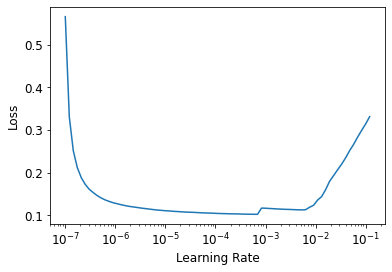

In [42]:
learn.unfreeze()
learn.lr_find()

In [43]:
learn.fit_one_cycle(12, lr_max=slice(1e-7,1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.101781,0.389693,0.884440,00:01
1,0.101982,0.389941,0.884277,00:01
2,0.101828,0.389358,0.884277,00:01
3,0.101835,0.389111,0.884359,00:01
4,0.101551,0.388944,0.884847,00:01
5,0.101393,0.388765,0.884766,00:01
6,0.101382,0.389295,0.884603,00:01
7,0.101469,0.388392,0.884847,00:01
8,0.101459,0.388097,0.884928,00:01
9,0.101191,0.388314,0.884847,00:01


In [44]:
learn.save('12epoch')

Path('models/12epoch.pth')

In [45]:
learn = learn.load('12epoch')
learn.unfreeze()
learn.fit_one_cycle(15, 1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.101533,0.388161,0.884847,00:01
1,0.101011,0.388323,0.884928,00:01
2,0.101335,0.387644,0.884928,00:01
3,0.100954,0.388002,0.884928,00:01
4,0.101208,0.387582,0.885010,00:01
5,0.101023,0.388548,0.884847,00:01
6,0.101016,0.387387,0.884928,00:01
7,0.100980,0.386999,0.885254,00:01
8,0.100989,0.387040,0.885661,00:01
9,0.101049,0.387381,0.885335,00:01


## Conclusion

이제 << chapter_nlp >>에서 텍스트 분류에 사용한 AWD-LSTM 아키텍처 내부의 모든 것을 보았습니다. 더 많은 곳에서 드롭 아웃을 사용합니다.

- Embedding dropout (임베딩 레이어 바로 뒤에)
- Input dropout (임베딩 레이어 이후)
- Weight dropout (각 훈련 단계에서 LSTM의 가중치에 적용)
- Hidden dropout (두 레이어 사이의 hidden state에 적용)

이것은 더 정규화됩니다. 5 개의 드롭 아웃 값 (출력 레이어 이전의 드롭 아웃 포함)을 미세 조정하는 것은 복잡하기 때문에 좋은 기본값을 결정하고 해당 장에서 본 'drop_mult'매개 변수를 사용하여 드롭 아웃 크기를 전반적으로 조정할 수 있습니다 ( 각 중도 별).

특히 "시퀀스-시퀀스"문제 (즉, 종속 변수 자체가 언어 번역과 같은 가변 길이 시퀀스 인 문제)에서 매우 강력한 또 다른 아키텍처는 Transformers 아키텍처입니다. [도서 웹 사이트] (https://book.fast.ai/)의 보너스 장에서 찾을 수 있습니다.

## Questionnaire

1. 프로젝트의 데이터 세트가 너무 크고 복잡해서 작업하는 데 상당한 시간이 걸리는 경우 어떻게해야할까요?
1. 언어 모델을 만들기 전에 데이터 세트의 문서를 연결하는 이유는 무엇입니까?
1. standard fully connected network(표준 완전 연결 네트워크)를 사용하여 앞의 세 단어에서 네 번째 단어를 예측하려면 모델링을 위해 어떤 두 가지 조정이 필요합니까?
1. PyTorch의 여러 레이어에서 가중치 매트릭스를 공유하려면 어떻게해야합니까?
1. 엿보기없이 문장의 이전 두 단어에서 세 번째 단어를 예측하는 모듈을 작성하십시오.
1. 순환 신경망(RNN)이란 무엇입니까?
1. "hidden state"란 무엇입니까?
1. `LMModel1`에서 hidden state 와 동등한 것은 무엇입니까?
1. TRNN에서 상태를 유지하려면 텍스트를 순서대로 모델에 전달하는 것이 중요한 이유는 무엇입니까?
1. RNN의 "언 롤링 된"표현이란 무엇입니까?
1. RNN에서 숨겨진 상태를 유지하면 메모리 및 성능 문제가 발생할 수있는 이유는 무엇입니까? 이 문제를 어떻게 해결합니까?
1. "BPTT"는 무엇입니까?
1. << chapter_nlp >>에서 IMDb 데이터 배치에 대해 보여준 것처럼 토큰 ID를 다시 영어 문자열로 변환하는 것을 포함하여 유효성 검사 세트의 처음 몇 배치를 인쇄하는 코드를 작성합니다.
1. `ModelResetter` 콜백은 무엇을합니까? 왜 필요합니까?
1. 세 개의 입력 단어마다 하나의 출력 단어 만 예측하는 단점은 무엇입니까?
1. 'LMModel4'에 대한 사용자 지정 손실 함수가 필요한 이유는 무엇입니까?
1. 'LMModel4'의 학습이 불안정한 이유는 무엇입니까?
1. 펼쳐진 표현에서 우리는 순환 신경망에 실제로 많은 계층이 있음을 알 수 있습니다. 그렇다면 더 나은 결과를 얻기 위해 RNN을 스택해야하는 이유는 무엇입니까?
1. 적층 (다층) RNN의 표현을 그립니다.
1. `detach`를 덜 자주 호출하면 왜 RNN에서 더 나은 결과를 얻어야합니까? 간단한 RNN으로 실제로 이것이 발생하지 않는 이유는 무엇입니까?
1. 딥 네트워크로 인해 활성화가 매우 크거나 아주 작게되는 이유는 무엇입니까? 이것이 왜 중요합니까?
1. 컴퓨터의 부동 소수점 숫자 표현에서 가장 정확한 숫자는 무엇입니까?
1. 그라디언트가 사라지면 훈련을 방해하는 이유는 무엇입니까?
1. LSTM 아키텍처에서 두 가지 숨겨진 상태를 갖는 것이 왜 도움이됩니까? 각각의 목적은 무엇입니까?
1. LSTM에서이 두 가지 상태는 무엇입니까?
1. tanh는 무엇이며 시그 모이 드와 어떤 관련이 있습니까?
1. `LSTMCell`에서이 코드의 목적은 무엇입니까 :`h = torch.stack ([h, input], dim = 1)`
1. PyTorch에서`chunk`는 무엇을합니까?
1. 'LSTMCell'의 리팩토링 된 버전을주의 깊게 연구하여 리팩터링되지 않은 버전과 동일한 작업을 수행하는 방법과 이유를 이해하십시오.
1. `LMModel6`에 더 높은 학습률을 사용할 수있는 이유는 무엇입니까?
1. AWD-LSTM 모델에서 사용되는 세 가지 정규화 기술은 무엇입니까?
1. "dropout"이란 무엇입니까?
1. 드롭 아웃으로 가중치를 확장하는 이유는 무엇입니까? 훈련, 추론 또는 둘 다에 적용됩니까?
1. `Dropout`에서이 줄의 목적은 무엇입니까 : ʻif self.training : return x`
1. 작동 방식을 이해하려면`bernoulli_`로 실험하십시오.
1. PyTorch의 훈련 모드에서 모델을 어떻게 설정합니까? 평가 모드에서?
1. 활성화 정규화를위한 방정식을 작성하십시오 (원하는대로 수학 또는 코드로). 체중 감소와 어떻게 다른가요?
1. 시간 활성화 정규화를위한 방정식을 작성하십시오 (원하는대로 수학 또는 코드로). 왜 이것을 컴퓨터 비전 문제에 사용하지 않습니까?
1. 언어 모델에서 "무게 묶기"란 무엇입니까?

### Further Research

1. `LMModel2`에서`forward`가`h = 0`으로 시작할 수있는 이유는 무엇입니까? 왜`h = torch.zeros (...)`라고 말할 필요가 없습니까?
1. LSTM에 대한 코드를 처음부터 작성하십시오 (<< lstm >> 참조).
1. 인터넷에서 GRU 아키텍처를 검색하고이를 처음부터 구현하고 모델을 학습 해보십시오. 이 장에서 본 것과 유사한 결과를 얻을 수 있는지 확인하십시오. 결과를 PyTorch의 'GRU'모듈에 내장 된 결과와 비교합니다.
1. fastai에서 AWD-LSTM의 소스 코드를 살펴보고 각 코드 행을이 장에 표시된 개념에 매핑 해보십시오.